
<h1 style="font-size: 24px; text-align: center;">Understanding Chest X-ray abnormalities </h1>
<h1 style="font-family: Lucida Sans Typewriter; font-size: 16px; text-align: center;"> Author- Sourabh Chauhan</h1>

# Contents of the notebook

 <a href="#1-Introduction"> 1. Introduction</a> 
 
 <a href="#2-Imports"> 2. Importing libraries</a> 
 
 <a href="#3-Reading data"> 3. Reading data </a>
 
 <a href="#4-Rad ID vs Class ID"> 4. Rad id vs Class id skewness </a> 

 <a href="#5-Conclusions from radiologists data skews"> 5. Conclusions from radiologist skews</a> 


 <a href="#6-Visualizing X-ray images "> 7. Visualizing X-ray images</a> 

<a href="#7-Merging boxes"> 7. Merging boxes</a> 

 <a href="# 6-No findings treatment"> 8. No findings treatment</a> 




# 1-Introduction
This Notebook is part of the [VinBigData Chest X-ray Abnormalities Detection](http://https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection) competition. If you find it useful, feel free to upvote. 


<h1 style="font-family: Verdana; font-size: 24px; text-align: left;">Problem Statement </h1>
In this competition, you’ll automatically localize and classify 14 types of thoracic abnormalities from chest radiographs. You'll work with a dataset consisting of 18,000 scans that have been annotated by experienced radiologists. You can train your model with 15,000 independently-labeled images and will be evaluated on a test set of 3,000 images. These annotations were collected via VinBigData's web-based platform, VinLab. Details on building the dataset can be found in our recent paper “VinDr-CXR: An open dataset of chest X-rays with radiologist's annotations”.


___

<h3 style="font-family: Verdana; font-size: 20px; text-align: left;"> Minor details </h3>

___

 * Images are blindly annotated with bounding boxes of 14 classes by 3 radiologists from a pool of 17, encoded with Rad IDs from R1 to R17.
 
 * The task is to automatically correctly predict boxes around abnormalities and classify them for the test images. Unlike the labels of the training set, those of the test set were already a consensus of 5 radiologists per image.
 
 
 ___

<h3 style="font-family: Verdana; font-size: 20px; text-align: left;"> Description of the data </h3>

___
 
* Format - DICOM (Digital Imaging and Communications in Medicine)
* Number of images in Training set - 15000
* Number of images in test set - 3000
* Number of classes - 14
* Number of radiologists - 17


 ****Metric for results****

* The test set contains 3000 images. The public score will be calculated on approx. 10% of the test set and will be visible to you during the competition. Final rankings will be determined on the remaining 90% i.e. private LB



 ___

<h3 style="font-family: Verdana; font-size: 20px; text-align: left;"> Pitfalls and intial questions</h3>
 
 ___   
    
    
[Ref1:- Following the welcome from host](http://https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/207741)
* Section 7.C. In general, repositories like detectron2, mmdet, torchvision, timm, efficientdet with pre-trained ImageNet/COCO/OpenImages models and datasets like Chexpert, MIMIC, PadChest are allowed
    
    
* Number of bounding boxes each image???? (multiple boxes were linked to same disease )

    * You need to think of creative ways to combine our provided bounding boxes in the train data set before conducting any experiment. 5 detections of a single object is counted as 1 correct detection and 4 false detections – it is the responsibility of the participant’s system to filter multiple detections from its output.
    
    * "For the test set, 5 radiologists involved into a two-stage labeling process. During the first stage, each image was independently annotated by 3 radiologists. In the second stage, 2 other radiologists, who have a higher level of experience, reviewed the annotations of the 3 previous annotators and communicated with each other in order to decide the final labels. The disagreements among initial annotators were carefully discussed and resolved by the 2 reviewers. Finally, the consensus of their opinions will serve as reference ground-truth."



[Ref2 :- Evaluation metric ](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/212287)


In [1]:
## Convert DCM to png, reference :- https://www.kaggle.com/onealbao/dicom-to-jpeg-conversion-kernel
# Convert to PNG via PIL 
# https://github.com/python-pillow/Pillow
#Learning DICOM format --> may be for later

# 2-Imports

In [2]:
from matplotlib import pyplot as plt
import glob
import pydicom ### to conver dicom to png images
from pydicom.pixel_data_handlers.util import apply_voi_lut ### don't know why???
import cv2 ## OpenCV package
from skimage import exposure ###  some preprocess like equalize histogram.

### imports for the bbox section
from PIL import Image
from sklearn import preprocessing
import random
from random import randint


# 3-Reading data

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [4]:
## Columns 
primary_dir = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/'
sample_sub = pd.read_csv(primary_dir +'sample_submission.csv')
train_csv = pd.read_csv(primary_dir +'train.csv')
test_csv = pd.read_csv(primary_dir +'train.csv')

print (train_csv.columns)
print (test_csv.columns)

print (sample_sub.columns)

Index(['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min',
       'x_max', 'y_max'],
      dtype='object')
Index(['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min',
       'x_max', 'y_max'],
      dtype='object')
Index(['image_id', 'PredictionString'], dtype='object')


Total number of rows in traning images are :- 67914
Unique training images :-  15000
Number of total radiologists:-  17
Number of total classes of diagnosis 15
{'Infiltration', 'Consolidation', 'ILD', 'Lung Opacity', 'No finding', 'Pleural thickening', 'Atelectasis', 'Calcification', 'Pneumothorax', 'Cardiomegaly', 'Other lesion', 'Aortic enlargement', 'Pulmonary fibrosis', 'Pleural effusion', 'Nodule/Mass'}


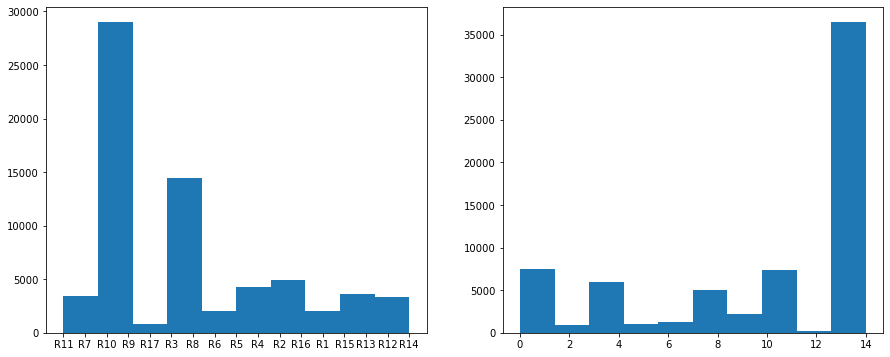

In [5]:
print ('Total number of rows in traning images are :-', len((train_csv['image_id']))) 
print ('Unique training images :- ', len(set(train_csv['image_id'])))
print ('Number of total radiologists:- ', len(set(train_csv['rad_id'])))
print ('Number of total classes of diagnosis', len(set(train_csv['class_name'])))
print (set(train_csv['class_name']))
fig,ax = plt.subplots(1,2, figsize = (15, 6))
ax[0].hist(train_csv['rad_id'])
ax[1].hist(train_csv['class_id'])
### 
plt.show()

# 4-Rad ID vs Class ID

image_id  class_name  x_min  y_min  x_max  y_max
rad_id class_id                                                  
R1     14            1995        1995      0      0      0      0
R10    0             2349        2349   2349   2349   2349   2349
       1              115         115    115    115    115    115
       2              139         139    139    139    139    139
       3             1835        1835   1835   1835   1835   1835
...                   ...         ...    ...    ...    ...    ...
R9     10            1045        1045   1045   1045   1045   1045
       11            2466        2466   2466   2466   2466   2466
       12              75          75     75     75     75     75
       13            1757        1757   1757   1757   1757   1757
       14            1979        1979      0      0      0      0

[155 rows x 6 columns]

array([[<AxesSubplot:title={'center':'R10'}>,
        <AxesSubplot:title={'center':'R11'}>,
        <AxesSubplot:title={'center':'R12'}>],
       [<AxesSubplot:title={'center':'R13'}>,
        <AxesSubplot:title={'center':'R14'}>,
        <AxesSubplot:title={'center':'R15'}>],
       [<AxesSubplot:title={'center':'R16'}>,
        <AxesSubplot:title={'center':'R17'}>,
        <AxesSubplot:title={'center':'R2'}>],
       [<AxesSubplot:title={'center':'R8'}>,
        <AxesSubplot:title={'center':'R9'}>, <AxesSubplot:>]],
      dtype=object)

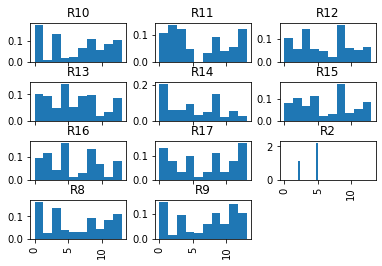

In [6]:
## lets try to understand how each of the radiologist is trying to characterize the X-rays 


df_test = train_csv.groupby(by = ['rad_id', 'class_id']).count()
display(df_test)
cond = train_csv['class_id'] !=14
train_csv[cond].class_id.hist(by=train_csv[cond].rad_id, sharey = False, sharex=True, density=1)


> ### That means Radiologist 1,2, 3, 4,5,6,7 are reporting only class_id=14 in their results which is ... 'no findings' in the X ray image. What to do about it 
* Should we just remove those radiologists from the sample??? 
    * Not a good idea to remove because may be these radiologists got only the images with features in their images.
    ---- Let us take a deeper look at those images -----> 

In [7]:
# Reference --- https://www.kaggle.com/leftyork/visual-in-depth-eda-vinbigdata-competition-data
import plotly.express as px
import plotly
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

# PRESETS
FIG_FONT = dict(family="Helvetica, Arial", size=14, color="#7f7f7f")
LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("coolwarm", 15)]
#LABEL_COLORS_WOUT_NO_FINDING = LABEL_COLORS[:8]+LABEL_COLORS[9:]

'''
fig = px.histogram(train_csv_good, x="rad_id", color="rad_id",opacity=0.85,
                   labels={"rad_id":"Radiologist ID"},
                   title="<b>Number of annotatons by the radiologists</b>", 
                  ).update_xaxes(categoryorder="total descending")
fig.update_layout(legend_title="<b>RADIOLOGIST ID</b>",
                  xaxis_title="<b>Radiologist ID</b>",
                  yaxis_title="<b>Number of Annotations Made</b>",
                  font=FIG_FONT,)
fig.show()'''


fig = go.Figure() ### PLOTLY graph object interesting usage 
int_2_str = {i:train_csv[train_csv["class_id"]==i].iloc[0]["class_name"] for i in range(15)}
str_2_int = {v:k for k,v in int_2_str.items()}
int_2_clr = {str_2_int[k]:LABEL_COLORS[i] for i,k in enumerate(sorted(str_2_int.keys()))}

for i in range(15):
    fig.add_trace(go.Histogram(
        y=train_csv[train_csv["class_id"]==i]["rad_id"],
        marker_color=int_2_clr[i],
        name=f"<b>{i, int_2_str[i]}</b>", orientation='h'))

fig.update_xaxes(categoryorder="total descending")
fig.update_layout(title="<b>Radiologsits annotation for each anamoly</b>",
                  barmode='stack',
                  xaxis_title="<b>Radiologist ID</b>",
                  yaxis_title="<b>Number of Annotations Made</b>",
                  font=FIG_FONT)
fig.show()


# 5-Conclusions from radiologists data skews
    
    * Most of the annotations come from 3 of the radiologists, R8, R9, R10. 
    * 7 out of 14 have 'No findings' as the output how to take care of this skew?


In [8]:
def get_bbox_area(row):
    return (row['x_max']-row['x_min'])*(row['y_max']-row['y_min'])
def get_bbox_height(row):
    return ((row['y_max']-row['y_min']))
def get_bbox_width(row):
    return (row['x_max']-row['x_min'])
def get_bbox_aspect_ratio(row):
    return ((row['x_max']-row['x_min'])/(row['y_max']-row['y_min']))

le = preprocessing.LabelEncoder()  # encode rad_id
train_csv['rad_label'] = le.fit_transform(train_csv['rad_id'])

train_csv_good = train_csv[train_csv['class_id'] != 14]
train_csv_good['bbox_area'] = train_csv_good.apply(get_bbox_area, axis=1)
train_csv_good['bbox_height'] = train_csv_good.apply(get_bbox_height, axis=1)
train_csv_good['bbox_width'] = train_csv_good.apply(get_bbox_width, axis=1)
train_csv_good['bbox_aspect_ratio'] = train_csv_good.apply(get_bbox_aspect_ratio, axis=1)

train_csv_good.head()




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,rad_label,bbox_area,bbox_height,bbox_width,bbox_aspect_ratio
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,1,438672.0,456.0,962.0,2.109649
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,1,95772.0,276.0,347.0,1.257246
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,16,24320.0,76.0,320.0,4.210526
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,8,1618084.0,1924.0,841.0,0.437110
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,16,15576.0,132.0,118.0,0.893939


In [9]:
fig = px.bar(x=[int_2_str[x] for x in range(14)], y=train_csv_good.groupby("class_id").mean()["bbox_aspect_ratio"], 
             color=[int_2_str[x] for x in range(14)], opacity=0.85,
             labels={"x":"Class Name", "y":"Aspect Ratio (W/H)"},
             title="<b>Aspect Ratios For Bounding Boxes By Class</b>",)
fig.update_layout(font=FIG_FONT,
                  yaxis_title="<b>Aspect Ratio (W/H)</b>",
                  xaxis_title=None,
                  legend_title_text=None)

fig.add_hline(y=1, line_width=2, line_dash="dot", 
              annotation_font_size=10, 
              annotation_text="<b>SQUARE ASPECT RATIO</b>", 
              annotation_position="bottom left", 
              annotation_font_color="black")
fig.show()

In [10]:
rad_id_bad = [1,3,4,5,6,7]

cond = (train_csv['class_id']==14) & (train_csv['rad_id']=='R1')
train_csv[cond].sample(n=4)
print ('Now let us look at those DICOM images')

Now let us look at those DICOM images


# 6- No findings treatment
An interesting result ... will come back to it later
[Check out this discussion on the topic.](http://https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/217886)

In [11]:

df_no_finding = train_csv[train_csv['class_id']==14]
### Using pivot table
#dups = df_no_finding.pivot_table(index = ['image_id'], aggfunc ='size') 
df_no_finding_duplicates = df_no_finding.groupby('image_id')['image_id'].count()
print((df_no_finding_duplicates.unique()))
print ('!!! All no findings are marked by 3 radiologists as no findings')
print ('Question:--- which 1000 images have real no findings ???')
cond1 = (df_no_finding['rad_id']== "R8") | (df_no_finding['rad_id']== "R9") | (df_no_finding['rad_id']== "R10")
n_no_finding_reliable = len(df_no_finding[ cond1]['image_id'].unique())
print ('For now how about we pick random 1000 images \
from the reliable radiologists, R8, R9, R10, out of ',n_no_finding_reliable)
#.groupby('rad_id').filter(lambda group: group.size > X)#.count().plot.bar()
#print (x.unique())
#df_no_finding.groupby(["rad_id"])rad_id.count().sort_values(ascending=False).head(20).plot.bar()



[3]
!!! All no findings are marked by 3 radiologists as no findings
Question:--- which 1000 images have real no findings ???
For now how about we pick random 1000 images from the reliable radiologists, R8, R9, R10, out of  3448


# 7-Visualizing X-ray images 

In [12]:

### Reference https://www.kaggle.com/trungthanhnguyen0502/eda-vinbigdata-chest-x-ray-abnormalities 

def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    '''
    new_shape = tuple([int(x / downscale_factor) for x in data.shape])
    data = cv2.resize(data, (new_shape[1], new_shape[0]))
    '''
    return data
        
    
def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=None): #(500,500)
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    #plt.show()


['/kaggle/input/vinbigdata-chest-xray-abnormalities-detection//train/50a418190bc3fb1ef1633bf9678929b3.dicom', '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection//train/21a10246a5ec7af151081d0cd6d65dc9.dicom', '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection//train/9a5094b2563a1ef3ff50dc5c7ff71345.dicom', '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection//train/051132a778e61a86eb147c7c6f564dfe.dicom']


/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning:

The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning:

The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value



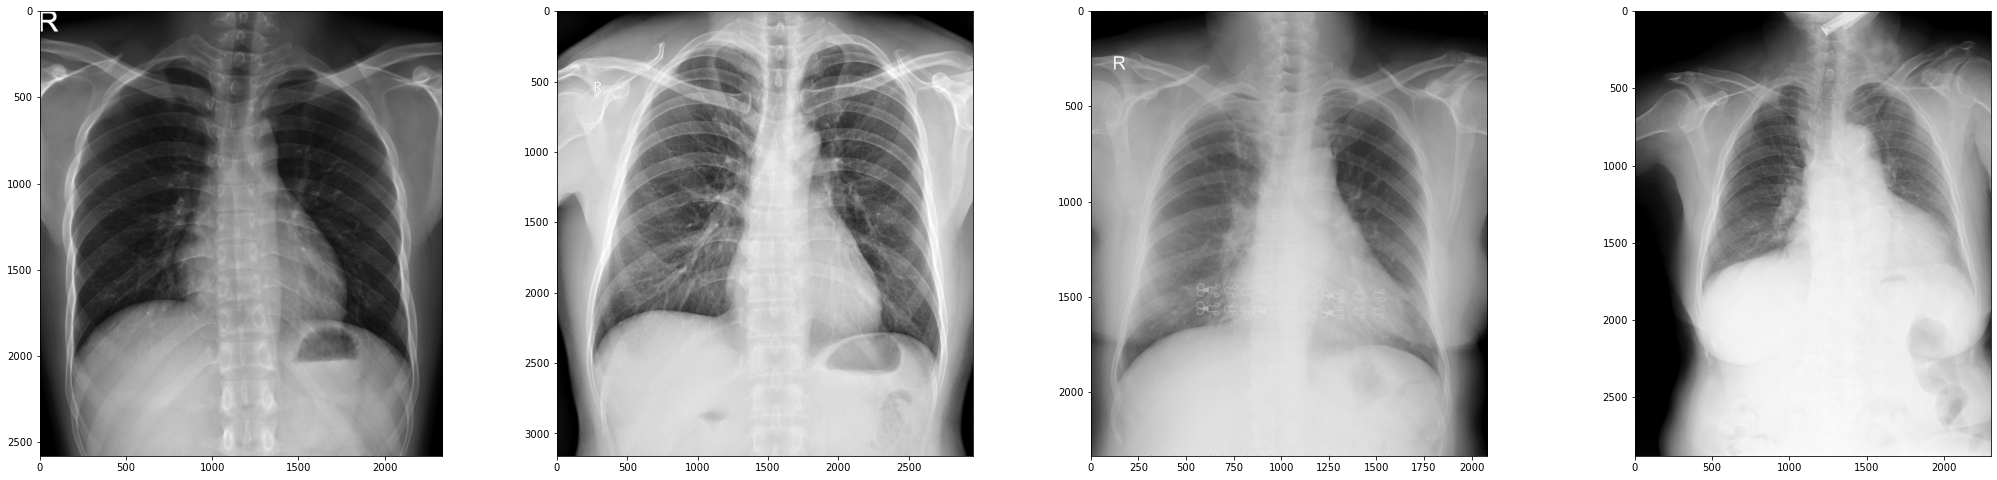

In [13]:
#dicom_paths = glob.glob(primary_dir+'/train/*.dicom')
dicom_paths = [primary_dir + '/train/'+train_csv['image_id'][x]+'.dicom' for x in range(4)]
print (dicom_paths)
imgs = [dicom2array(path) for path in dicom_paths[:4]]
plot_imgs(imgs, size=9)

In [14]:
### not sure if we need this.
#imgs = [exposure.equalize_hist(img) for img in imgs]
#plot_imgs(imgs)

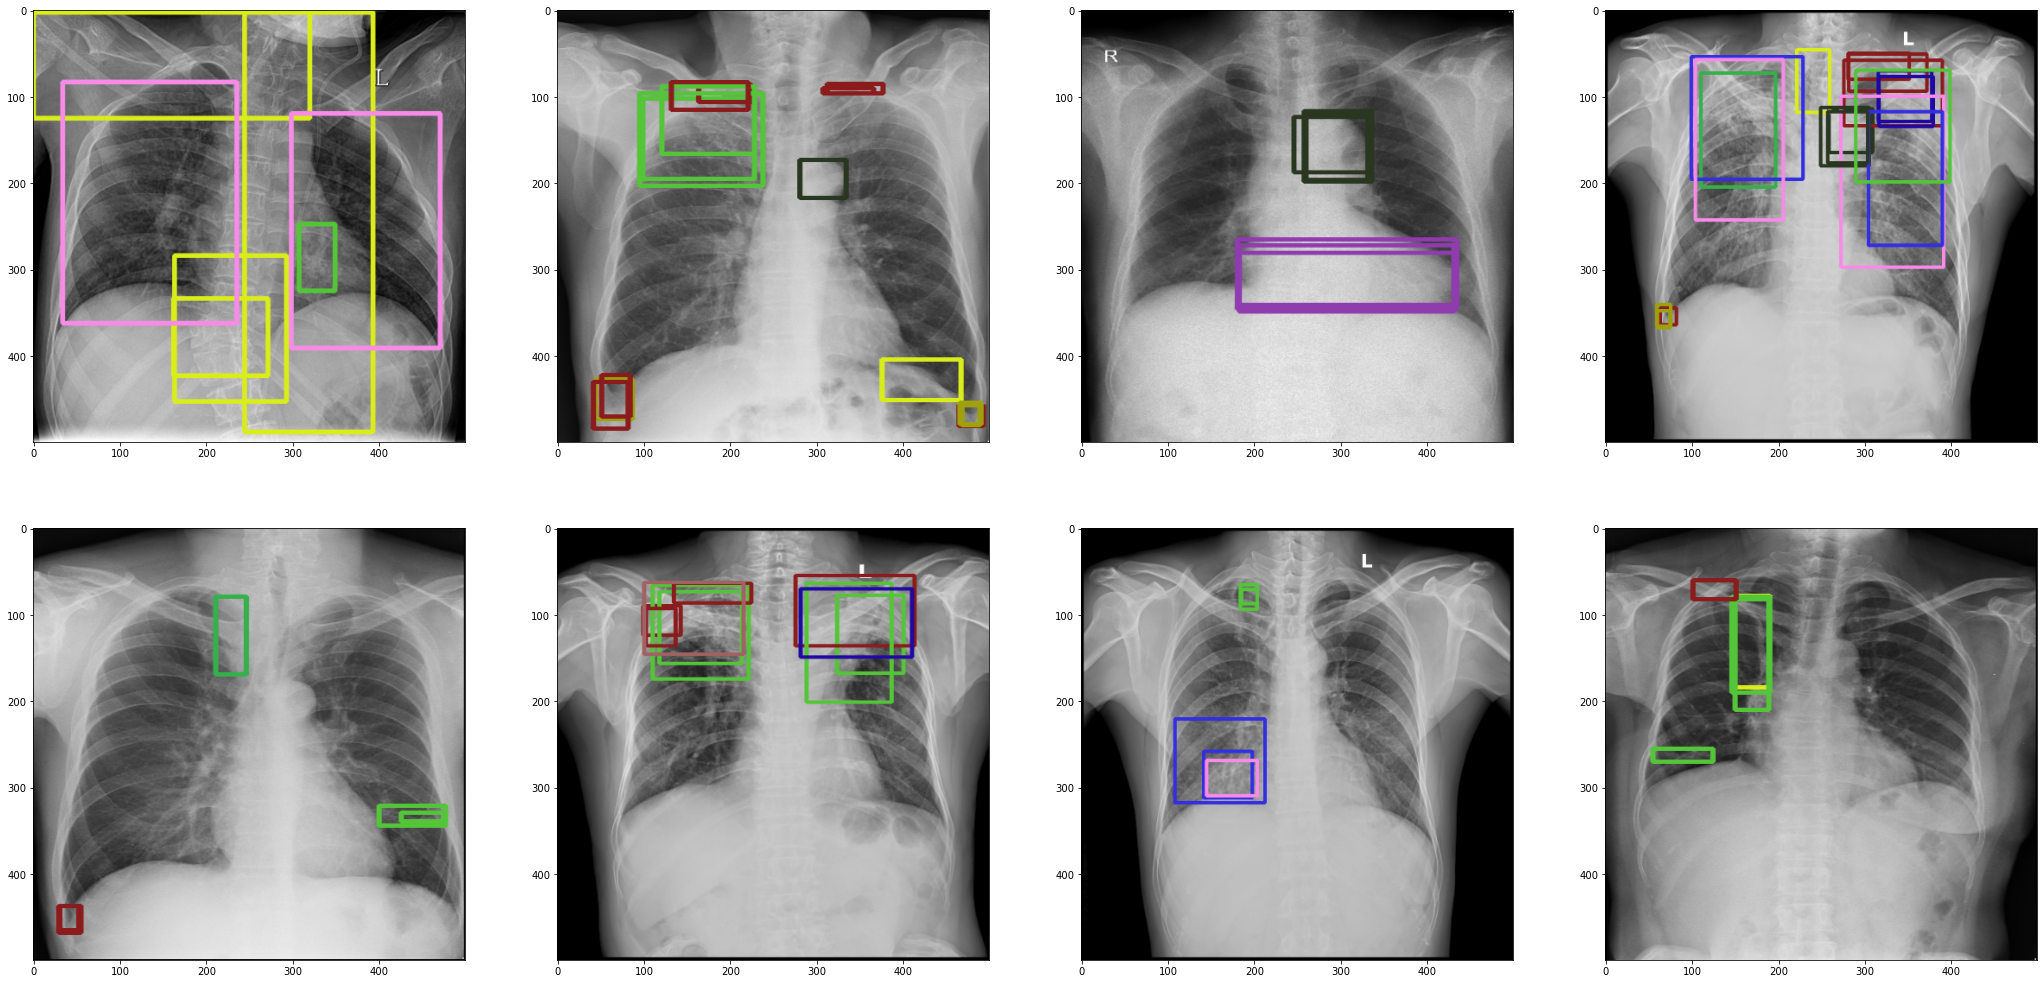

In [15]:
imgs = []
img_ids = train_csv_good['image_id'].values
class_ids = train_csv_good['class_id'].unique()

# map label_id to specify color
label2color = {class_id:[randint(0,255) for i in range(3)] for class_id in class_ids}
thickness = 3
scale = 5


for i in range(8):
    img_id = random.choice(img_ids)
    img_path = primary_dir+f'/train/{img_id}.dicom'
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    boxes = train_csv_good.loc[train_csv_good['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values/scale
    labels = train_csv_good.loc[train_csv_good['image_id'] == img_id, ['class_id']].values.squeeze()
    
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id]
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
        
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs, size = 9, cmap=None)
plt.show()

# 8-Merging boxes

[Follwing this notebook
](https://www.kaggle.com/sreevishnudamodaran/vinbigdata-fusing-bboxes-coco-dataset)

In [16]:
print('Number of total good annotations', len(train_csv_good['image_id']))
print('Number of unique image with good annotations', len(train_csv_good['image_id'].unique()))
print ('Original data including NO findings',  len(train_csv), len(train_csv['image_id'].unique()))

Number of total good annotations 36096
Number of unique image with good annotations 4394
Original data including NO findings 67914 15000


In [17]:
!pip install ensemble_boxes
#https://github.com/ZFTurbo/Weighted-Boxes-Fusion
from ensemble_boxes import nms, weighted_boxes_fusion
from path import Path
from collections import Counter


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



47ed17dcb2cbeec15182ed335a8b5a9e


/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning:

The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value



d3637a1935a905b3c326af31389cb846
afb6230703512afc370f236e8fe98806
7c1add6833d5f0102b0d3619a1682a64


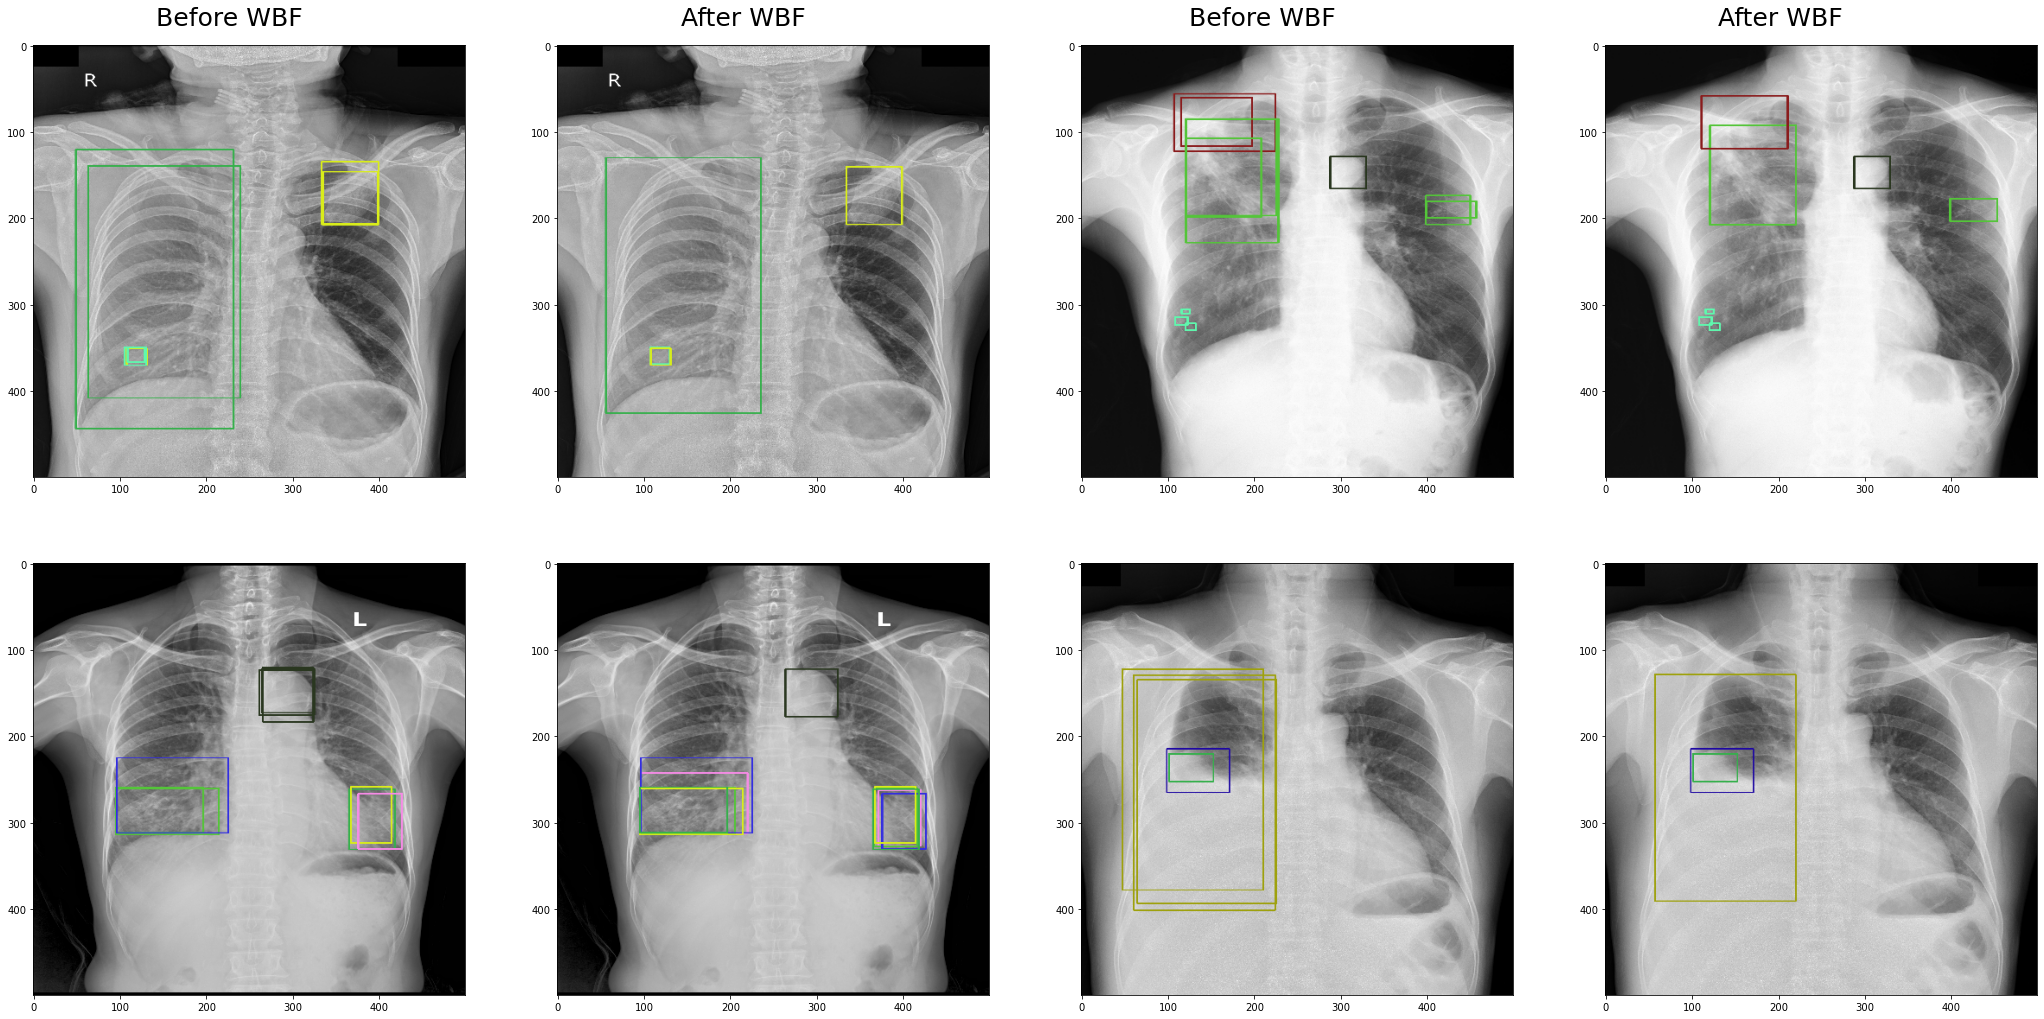

In [18]:

iou_thr = 0.5
skip_box_thr = 0.0001
final_images = []
sigma = 0.1

thickness = 3 
scale = 5



train_csv_good['image_path_dicom'] = train_csv_good['image_id'].map(lambda x:os.path.join(primary_dir + '/train', str(x)+'.dicom'))
image_paths = train_csv_good['image_path_dicom'].unique()


for i, path in enumerate(image_paths[4:8]):
    #print (path)
    img_array = dicom2array(path=path)
    img_basename = Path(path).stem
    print (img_basename)
    img_annotations = train_csv_good[train_csv_good.image_id==img_basename]
    
    
    ### plotting the image before merging the boxes
    
    boxes_before = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_before = img_annotations['class_id'].to_numpy().tolist()
    
    
    img_array = np.stack([img_array, img_array, img_array], axis=-1)

    img_before = img_array.copy()
    for box, label in zip(boxes_before, labels_before):
        color = label2color[int(label)]
        img_before = cv2.rectangle(img_before,\
                                   (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),\
                                   color = color, thickness =10)

    
    img_before = cv2.resize(img_before, (500,500))
    final_images.append(img_before)
    ##########################
    ### Start meging now After
    ##########
    '''
    # from the github repo. ---https://github.com/ZFTurbo/Weighted-Boxes-Fusion
    boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    
        
    boxes_list = [[
    [0.00, 0.51, 0.81, 0.91],
    [0.10, 0.31, 0.71, 0.61],
    [0.01, 0.32, 0.83, 0.93],
    [0.02, 0.53, 0.11, 0.94],
    [0.03, 0.24, 0.12, 0.35],
    ],[
    [0.04, 0.56, 0.84, 0.92],
    [0.12, 0.33, 0.72, 0.64],
    [0.38, 0.66, 0.79, 0.95],
    [0.08, 0.49, 0.21, 0.89],
    ]]
    scores_list = [[0.9, 0.8, 0.2, 0.4, 0.7], [0.5, 0.8, 0.7, 0.3]]
    labels_list = [[0, 1, 0, 1, 1], [1, 1, 1, 0]]
    weights = [2, 1]

    iou_thr = 0.5
    skip_box_thr = 0.0001
    sigma = 0.1
    
    '''
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    ### when no need to merge as we have only one box
    boxes_single = []
    labels_single = []
    
    unique_classes = img_annotations['class_id'].unique().tolist()
    count_classes = Counter(img_annotations['class_id'].tolist())

    for cls in unique_classes:       
        ## when there is only one box --- no need to do anything
        if count_classes[cls]==1:
            labels_single.append(cls)
            boxes_single.append(img_annotations[img_annotations.class_id==cls][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())
        ### multiple boxes then do merging based on iou
        else:
            cls_list = img_annotations[img_annotations.class_id==cls]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cls][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
        
            ## remember to normalize the bbox for image size
        
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            ## the github code needs boxes_list relative to image size 

            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())
            ## weights are meanignless here if we are using just one method to fuse the boxes
            weights.append(1)
            

    # Perform the fusion now
    boxes, scores, box_labels= weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights,
                                                     iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    # rescale boxes back to normal
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()

    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    
    ## Visualize Bboxes after operation
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        color = label2color[int(label)]
        img_after = cv2.rectangle(img_after,\
                                   (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),\
                                   color = color, thickness =10)

    img_after = cv2.resize(img_after, (500,500))

    final_images.append(img_after)

    
plot_imgs(final_images, size=9,)
plt.figtext(0.20, 0.9," Before WBF", va="top", ha="center", size=25)
plt.figtext(0.60, 0.9,"Before WBF", va="top", ha="center", size=25)

plt.figtext(0.40, 0.9,"After WBF", va="top", ha="center", size=25)
plt.figtext(0.80, 0.9,"After WBF", va="top", ha="center", size=25)

plt.show()


# Next steps
- understand the bounding box statistics more carefully. Look for the skewness in them 
- Get rid of overlapping bounding boxes. 
- MaskRCNN for making the bounding boxes 
- Faster RCNN + FPN for training the images with findings
- Train 2 class with resnet34
- combine both the results from the traning 


In [19]:
# https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/212287
def iou_calculator(bbox_1, bbox_2):
    ## overlap area/total area
    ### determine the edges of the overlap
    x_left = max(bbox_1[0], bbox_2[0])
    y_top = max(bbox_1[1], bbox_2[1])
    x_right = min(bbox_1[2], bbox_2[2])
    y_bottom = min(bbox_1[3], bbox_2[3])
    # do the boxes overlap???
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    else:
        overlap_area = (x_right - x_left) * (y_bottom - y_top)
        bbox_1_area = (bbox_1[2] - bbox_1[0]) * (bbox_1[3] - bbox_1[1])
        bbox_2_area = (bbox_2[2] - bbox_2[0]) * (bbox_2[3] - bbox_2[1])
        
        iou = overlap_area / float(bbox_1_area + bbox_2_area - overlap_area)
        return iou

In [20]:
'''
Image preprocessing 
Using this https://github.com/sneddy/pneumothorax-segmentation

albu.Compose([
    albu.HorizontalFlip(),
    albu.OneOf([
        albu.RandomContrast(),
        albu.RandomGamma(),
        albu.RandomBrightness(),
        ], p=0.3),
    albu.OneOf([
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        albu.GridDistortion(),
        albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    albu.ShiftScaleRotate(),
    albu.Resize(img_size,img_size,always_apply=True),
])
'''

'\nImage preprocessing \nUsing this https://github.com/sneddy/pneumothorax-segmentation\n\nalbu.Compose([\n    albu.HorizontalFlip(),\n    albu.OneOf([\n        albu.RandomContrast(),\n        albu.RandomGamma(),\n        albu.RandomBrightness(),\n        ], p=0.3),\n    albu.OneOf([\n        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),\n        albu.GridDistortion(),\n        albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),\n        ], p=0.3),\n    albu.ShiftScaleRotate(),\n    albu.Resize(img_size,img_size,always_apply=True),\n])\n'